<a href="https://colab.research.google.com/github/Narenderreddyranabothu/DataScience-Project/blob/main/P_and_O_of_smart_grids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

# This will open a file picker dialog
uploaded = files.upload()

Saving household_power_consumption.txt to household_power_consumption.txt


In [2]:
import warnings
warnings.filterwarnings("ignore") # For suppressing warnings

import pandas as pd  # For data handling
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns  # For prettier graphs
from sklearn.model_selection import train_test_split  # For splitting data
from sklearn.ensemble import RandomForestRegressor  # For building a prediction model
from sklearn.metrics import mean_squared_error, mean_absolute_error  # For evaluating the model
from datetime import datetime  # For handling dates
from sklearn.preprocessing import StandardScaler  # For scaling data
import statsmodels.api as sm  # For statistical analysis

In [3]:
# Load the dataset
df = pd.read_csv('household_power_consumption.txt', sep=';', low_memory=False)

In [4]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [5]:
print('Total number of data points in the dataset:', len(df))

Total number of data points in the dataset: 2075259


# Data Cleaning


In [6]:
missing_values_count = df.isnull().sum()
total_missing = missing_values_count.sum()

print("Missing values per column:\n", missing_values_count)
print(f"\nTotal missing values in dataset: {total_missing}")

Missing values per column:
 Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

Total missing values in dataset: 25979


In [7]:
df = df.dropna()

In [8]:
missing_values_count = df.isnull().sum()
total_missing = missing_values_count.sum()

print("Missing values per column:\n", missing_values_count)
print(f"\nTotal missing values in dataset: {total_missing}")

Missing values per column:
 Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

Total missing values in dataset: 0


In [9]:
print('Total number of data points in the dataset (Missing values removed):', len(df))

Total number of data points in the dataset (Missing values removed): 2049280


In [10]:
dx = df.copy()

In [11]:
dx['Datetime'] = pd.to_datetime(dx['Date'] + ' ' + dx['Time'], dayfirst=True)

# Set Datetime as index
dx.set_index('Datetime', inplace=True)

# Drop the old Date and Time columns safely
dx = dx.drop(['Date', 'Time'], axis=1)

# Convert all columns to numeric, coercing errors (non-numeric to NaN)
for col in dx.columns:
    dx[col] = pd.to_numeric(dx[col], errors='coerce')

# Now resample by hour and take the mean
dx = dx.resample('h').mean()

In [12]:
dx = dx.reset_index()
dx.head()

,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
1,2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2,2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
3,2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
4,2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


In [13]:
print('Total number of data points in the dataset (Update: Minutes to Hourly):', len(dx))

Total number of data points in the dataset (Update: Minutes to Hourly): 34589


# Feature Engineering


In [14]:
# Total Sub-Metered Energy
dx['Total_sub_metering'] = dx['Sub_metering_1'] + dx['Sub_metering_2'] + dx['Sub_metering_3']

In [15]:
dx.head()

,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Total_sub_metering
0,2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,17.388889
1,2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667,23.583333
2,2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333,18.116667
3,2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333,16.783333
4,2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667,17.633333


In [16]:
# Global Active Power is in kilowatts. Convert it to watt-minutes per minute interval (1 kW = 1000 watts)
dx['Global_active_energy'] = dx['Global_active_power'] * 1000 / 60  # Watt-minute per minute

# Unmetered Energy - residual power use not captured by sub-metering
dx['Unmetered_energy'] = dx['Global_active_energy'] - dx['Total_sub_metering']

In [17]:
dx.head()

,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Total_sub_metering,Global_active_energy,Unmetered_energy
0,2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,17.388889,70.381481,52.992593
1,2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667,23.583333,60.536667,36.953333
2,2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333,18.116667,56.670556,38.553889
3,2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333,16.783333,54.476111,37.692778
4,2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667,17.633333,50.941111,33.307778


In [18]:
# Reactive/Active Power Ratio
# Helps in analysing power quality and energy efficiency

dx['Power_factor_proxy'] = dx['Global_reactive_power'] / (dx['Global_active_power'] + 1e-6)  # adding a small noise to avoid division by zero

In [19]:
# Load Categories
# Categorising total power usage levels

dx['Load_category'] = pd.cut(dx['Global_active_power'], bins = [0, 2, 4, dx['Global_active_power'].max()],
                             labels = ['Low', 'Medium', 'High'])

In [20]:
dx.head()

,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Total_sub_metering,Global_active_energy,Unmetered_energy,Power_factor_proxy,Load_category
0,2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,17.388889,70.381481,52.992593,0.054228,High
1,2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667,23.583333,60.536667,36.953333,0.022034,Medium
2,2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333,18.116667,56.670556,38.553889,0.025067,Medium
3,2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333,16.783333,54.476111,37.692778,0.022976,Medium
4,2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667,17.633333,50.941111,33.307778,0.025083,Medium


# Exploratory Data Analysis


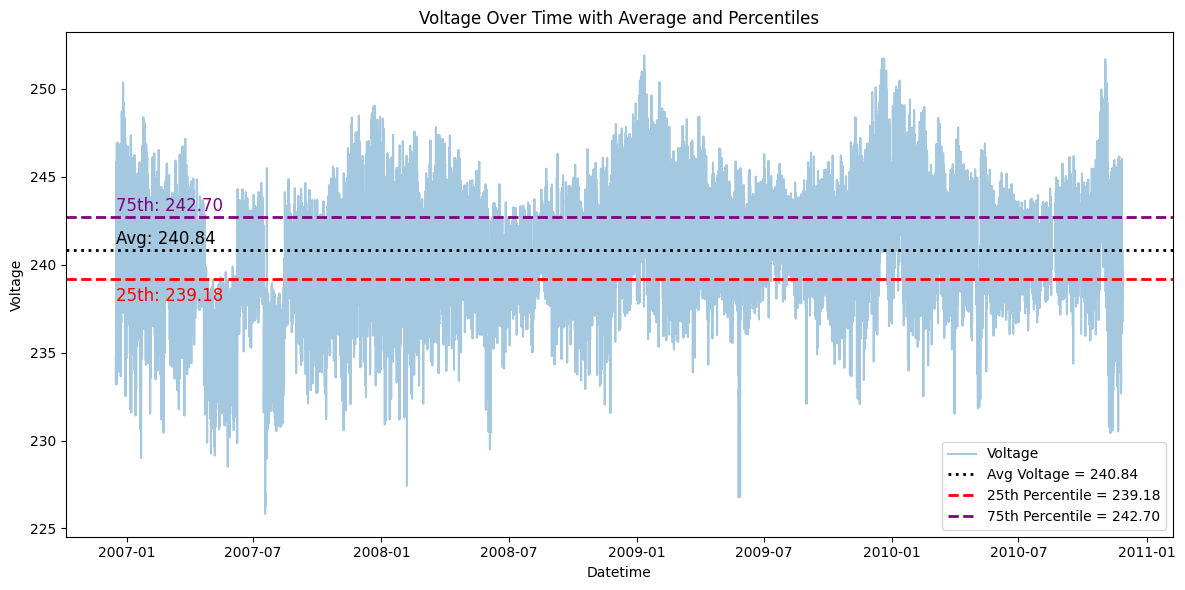

In [21]:
avg_voltage = dx['Voltage'].mean()
q25 = dx['Voltage'].quantile(0.25)
q75 = dx['Voltage'].quantile(0.75)

plt.figure(figsize=(12, 6))
plt.plot(dx['Datetime'], dx['Voltage'], label='Voltage', alpha=0.4)

plt.axhline(y=avg_voltage, color='black', linestyle=':', linewidth=2, label=f'Avg Voltage = {avg_voltage:.2f}')
plt.text(dx['Datetime'].iloc[0], avg_voltage + 0.1, f'Avg: {avg_voltage:.2f}', color='black', fontsize=12, verticalalignment='bottom')

plt.axhline(y=q25, color='red', linestyle='--', linewidth=2, label=f'25th Percentile = {q25:.2f}')
plt.text(dx['Datetime'].iloc[0], q25 - 1.5, f'25th: {q25:.2f}', color='red', fontsize=12, verticalalignment='bottom')

plt.axhline(y=q75, color='purple', linestyle='--', linewidth=2, label=f'75th Percentile = {q75:.2f}')
plt.text(dx['Datetime'].iloc[0], q75 + 0.1, f'75th: {q75:.2f}', color='purple', fontsize=12, verticalalignment='bottom')

plt.title('Voltage Over Time with Average and Percentiles')
plt.xlabel('Datetime')
plt.ylabel('Voltage')
plt.legend()
plt.tight_layout()
plt.show()

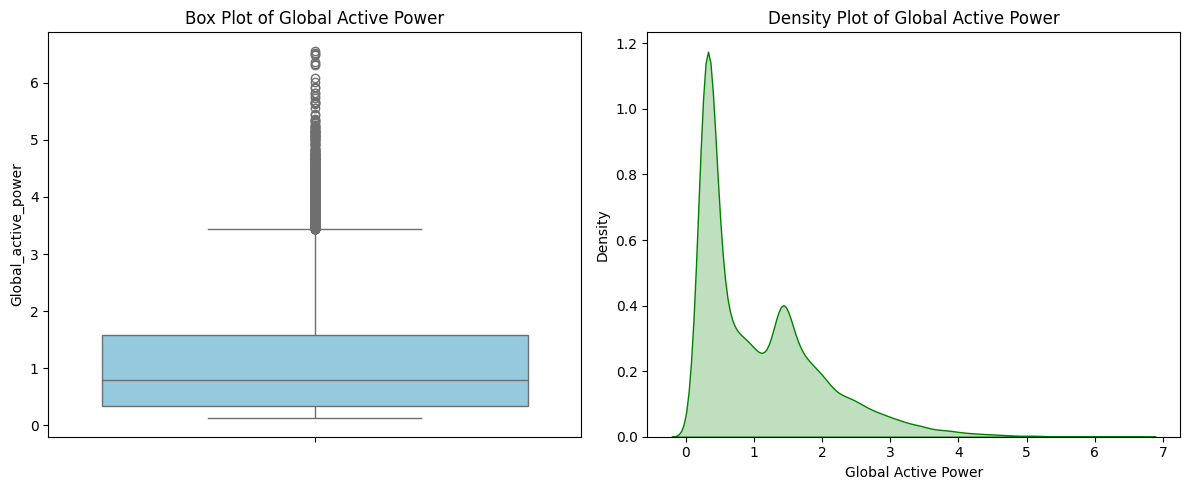

In [22]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(y=dx['Global_active_power'], color='skyblue')
plt.title('Box Plot of Global Active Power')

plt.subplot(1, 2, 2)
sns.kdeplot(dx['Global_active_power'], shade=True, color='green')
plt.title('Density Plot of Global Active Power')
plt.xlabel('Global Active Power')

plt.tight_layout()
plt.show()

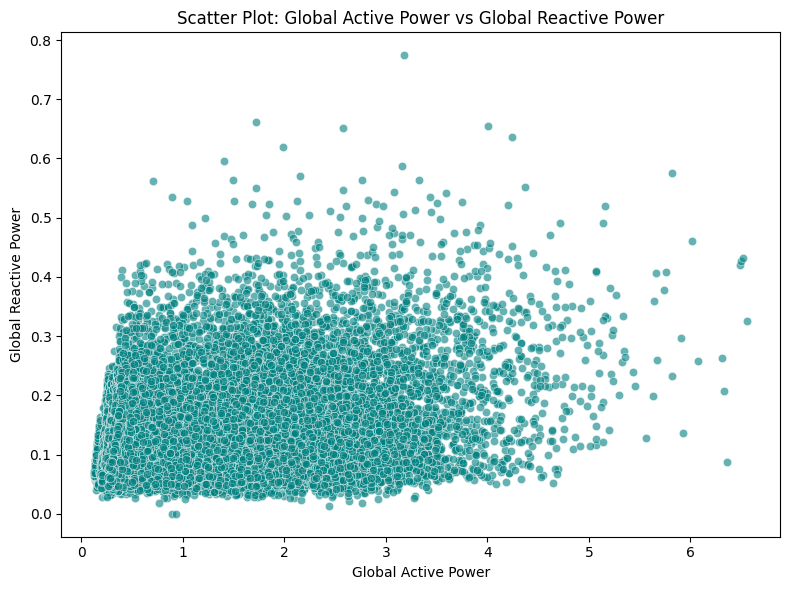

In [24]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=dx['Global_active_power'], y=dx['Global_reactive_power'], alpha=0.6, color='teal')
plt.title('Scatter Plot: Global Active Power vs Global Reactive Power')
plt.xlabel('Global Active Power')
plt.ylabel('Global Reactive Power')
plt.tight_layout()
plt.show()

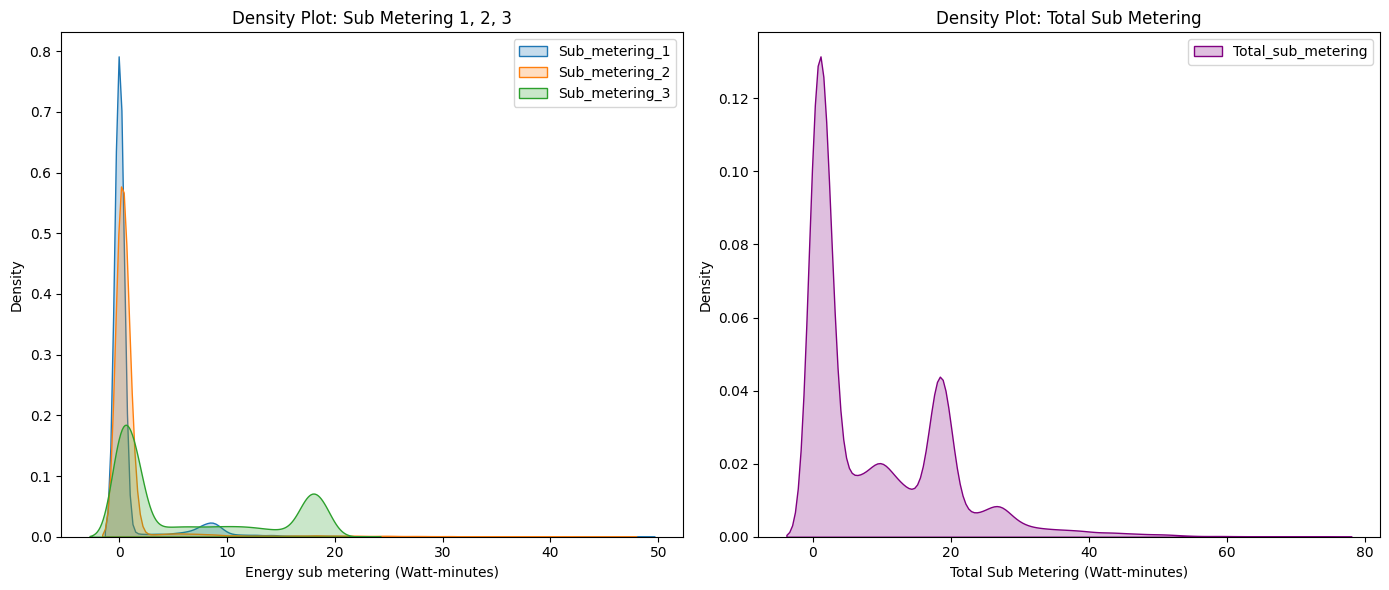

In [25]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.kdeplot(dx['Sub_metering_1'], label='Sub_metering_1', shade=True)
sns.kdeplot(dx['Sub_metering_2'], label='Sub_metering_2', shade=True)
sns.kdeplot(dx['Sub_metering_3'], label='Sub_metering_3', shade=True)
plt.title('Density Plot: Sub Metering 1, 2, 3')
plt.xlabel('Energy sub metering (Watt-minutes)')
plt.ylabel('Density')
plt.legend()

plt.subplot(1, 2, 2)
sns.kdeplot(dx['Total_sub_metering'], label='Total_sub_metering', shade=True, color='purple')
plt.title('Density Plot: Total Sub Metering')
plt.xlabel('Total Sub Metering (Watt-minutes)')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

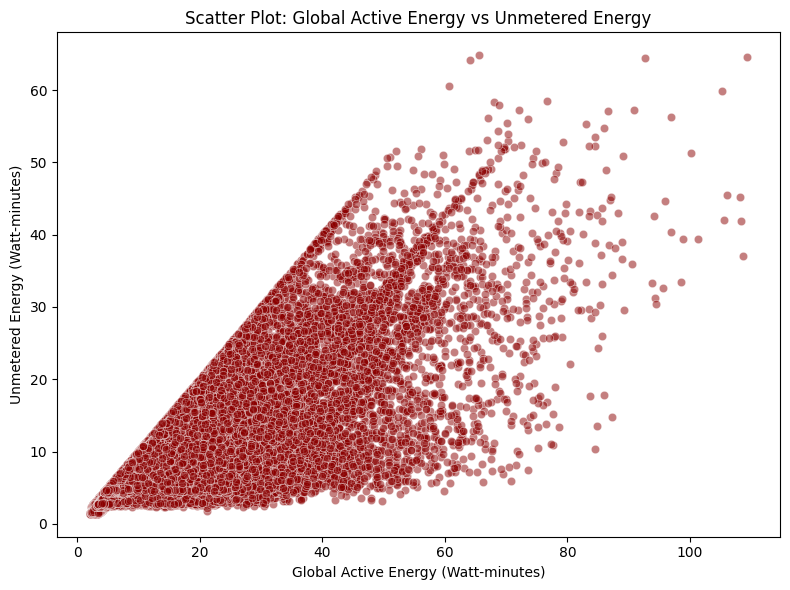

In [26]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=dx['Global_active_energy'], y=dx['Unmetered_energy'], alpha=0.5, color='darkred')

plt.title('Scatter Plot: Global Active Energy vs Unmetered Energy')
plt.xlabel('Global Active Energy (Watt-minutes)')
plt.ylabel('Unmetered Energy (Watt-minutes)')
plt.tight_layout()
plt.show()

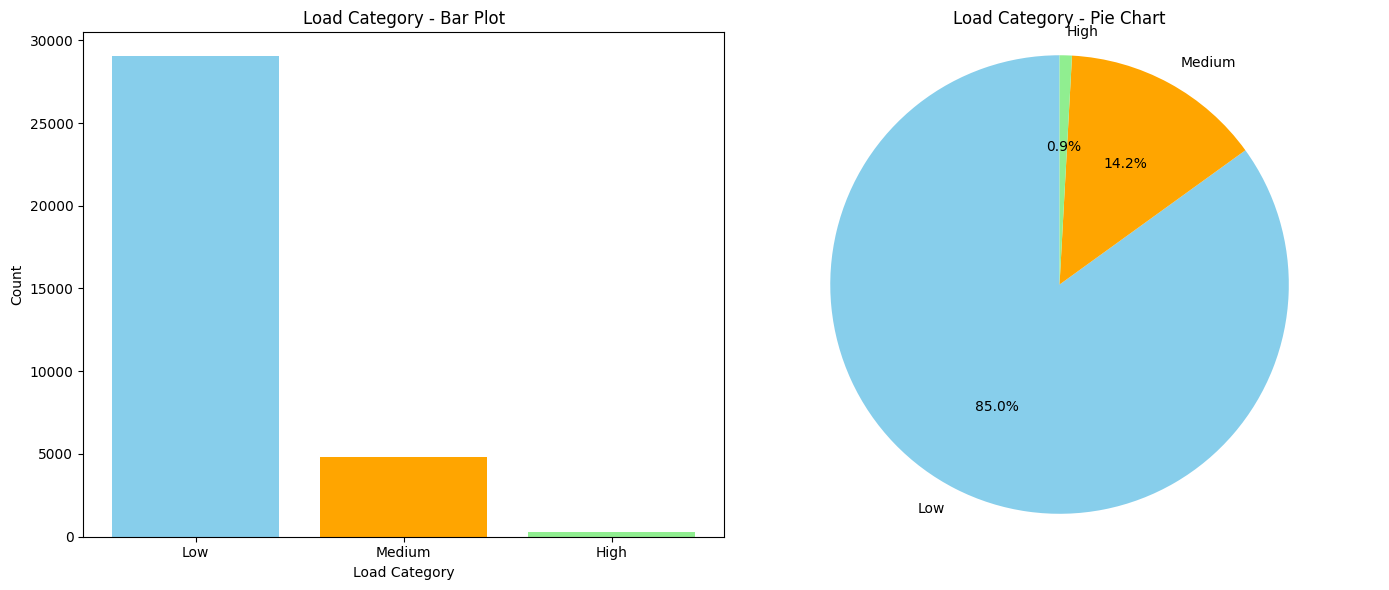

In [27]:
load_counts = dx['Load_category'].value_counts()
labels = load_counts.index
sizes = load_counts.values

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].bar(labels, sizes, color=['skyblue', 'orange', 'lightgreen'])
axs[0].set_title('Load Category - Bar Plot')
axs[0].set_xlabel('Load Category')
axs[0].set_ylabel('Count')

axs[1].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange', 'lightgreen'])
axs[1].axis('equal')
axs[1].set_title('Load Category - Pie Chart')

plt.tight_layout()
plt.show()

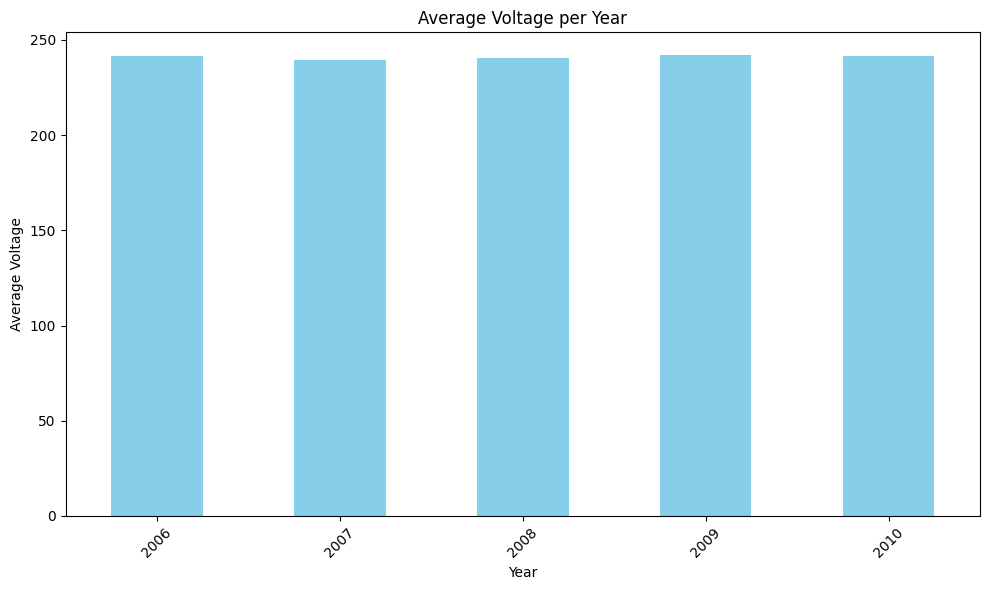

In [28]:
dx['Datetime'] = pd.to_datetime(dx['Datetime'])

dx['Year'] = dx['Datetime'].dt.year
avg_voltage_per_year = dx.groupby('Year')['Voltage'].mean()
plt.figure(figsize=(10, 6))
avg_voltage_per_year.plot(kind='bar', color='skyblue')

plt.title('Average Voltage per Year')
plt.xlabel('Year')
plt.ylabel('Average Voltage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

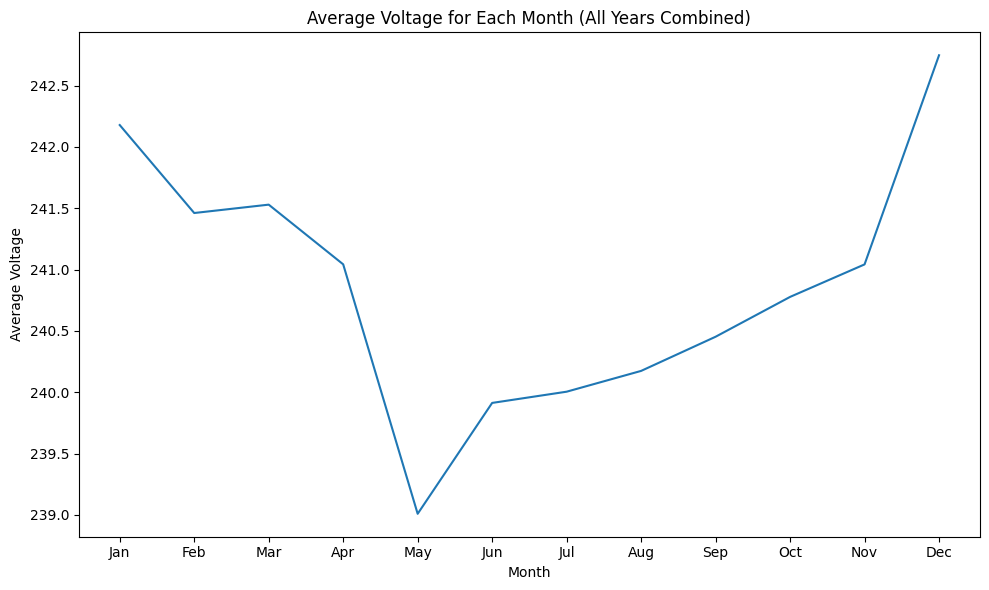

In [29]:
dx['Datetime'] = pd.to_datetime(dx['Datetime'])
dx['Month'] = dx['Datetime'].dt.month
monthly_avg = dx.groupby('Month')['Voltage'].mean()

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(10, 6))
plt.plot(monthly_avg.index, monthly_avg.values, linestyle='-')
plt.xticks(ticks=range(1, 13), labels=months)
plt.title('Average Voltage for Each Month (All Years Combined)')
plt.xlabel('Month')
plt.ylabel('Average Voltage')
plt.tight_layout()
plt.show()

# Pre - Processing


In [30]:
dx.head()

,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Total_sub_metering,Global_active_energy,Unmetered_energy,Power_factor_proxy,Load_category,Year,Month
0,2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,17.388889,70.381481,52.992593,0.054228,High,2006,12
1,2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667,23.583333,60.536667,36.953333,0.022034,Medium,2006,12
2,2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333,18.116667,56.670556,38.553889,0.025067,Medium,2006,12
3,2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333,16.783333,54.476111,37.692778,0.022976,Medium,2006,12
4,2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667,17.633333,50.941111,33.307778,0.025083,Medium,2006,12


In [31]:
dx.drop('Datetime', axis=1, inplace=True)

In [32]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
dx['Load_category'] = le.fit_transform(dx['Load_category'])

In [33]:
from sklearn.preprocessing import StandardScaler

In [34]:
exclude_cols = ['Voltage', 'Load_category', 'Year', 'Month']

scale = dx.select_dtypes(include=['number']).columns.difference(exclude_cols)
scaler = StandardScaler()
dx[scale] = scaler.fit_transform(dx[scale])

In [35]:
dx.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Total_sub_metering,Global_active_energy,Unmetered_energy,Power_factor_proxy,Load_category,Year,Month
0,3.488347,1.574758,234.643889,3.585068,-0.317025,-0.183836,1.415055,0.828954,3.488347,5.279151,-0.894137,0,2006,12
1,2.830276,-0.653610,234.580167,2.919775,-0.317025,1.292235,1.415811,1.432364,2.830276,3.340483,-1.090411,2,2006,12
2,2.571848,-0.575824,233.232500,2.627933,-0.317025,0.032143,1.390872,0.899847,2.571848,3.533942,-1.071923,2,2006,12
3,2.425161,-0.727407,234.071500,2.471811,-0.317025,-0.309712,1.404475,0.769965,2.425161,3.429860,-1.084668,2,2006,12
4,2.188866,-0.703971,237.158667,2.240289,-0.317025,-0.210336,1.463423,0.852765,2.188866,2.899844,-1.071822,2,2006,12


In [36]:
dx = dx.dropna()

In [37]:
x = dx.drop(['Voltage'], axis=1)
y = dx['Voltage']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(f"Training set size: {x_train.shape[0]} samples")
print(f"Testing set size: {x_test.shape[0]} samples")

Training set size: 27334 samples
Testing set size: 6834 samples


# Linear Regression

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [39]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_train)

train_mse = mean_squared_error(y_train, y_pred)
train_rmse = np.sqrt(train_mse)

print(f"Train Mean Squared Error: {train_mse}")
print(f"Train Root Mean Squared Error: {train_rmse}")

Train Mean Squared Error: 5.199250685803492
Train Root Mean Squared Error: 2.2801865462728026


In [40]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)

print(f"Test Mean Squared Error: {test_mse}")
print(f"Test Root Mean Squared Error: {test_rmse}")

Test Mean Squared Error: 5.297859619843145
Test Root Mean Squared Error: 2.3017079788372685


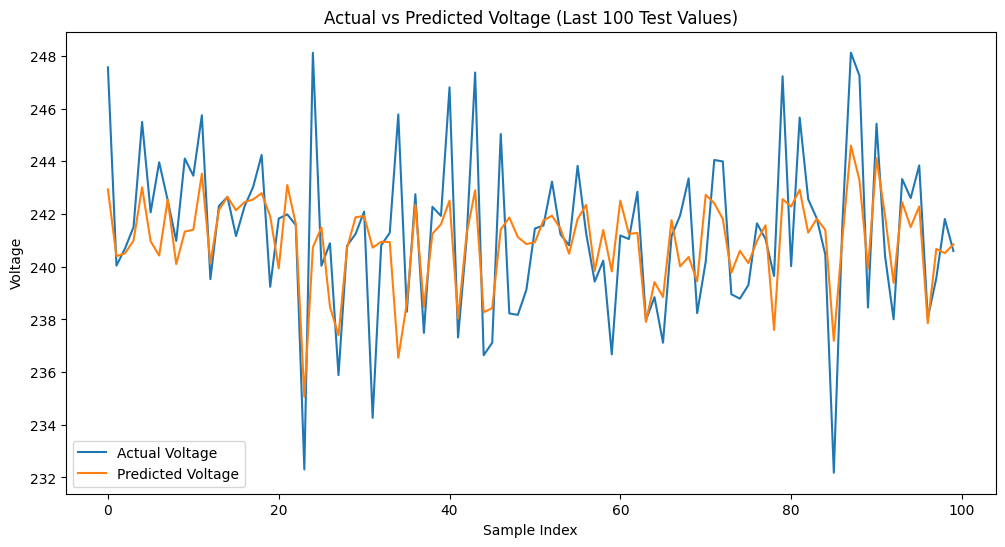

In [42]:
y_test_last = y_test[-100:].reset_index(drop=True)
y_pred_last = y_pred[-100:]

# Plotting actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_last, label='Actual Voltage')
plt.plot(y_pred_last, label='Predicted Voltage')
plt.title('Actual vs Predicted Voltage (Last 100 Test Values)')
plt.xlabel('Sample Index')
plt.ylabel('Voltage')
plt.legend()
plt.show()

# Random Forest Regression


In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [43]:
random_forest = RandomForestRegressor()
param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [10, 50, 100]}

grid_search = GridSearchCV(random_forest, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)

print('Best Hyperparameters:', grid_search.best_params_)

y_pred = grid_search.predict(x_train)
train_mse = mean_squared_error(y_train, y_pred)
train_rmse = np.sqrt(train_mse)

print(f"Train Mean Squared Error: {train_mse}")
print(f"Train Root Mean Squared Error: {train_rmse}")

Best Hyperparameters: {'max_depth': 100, 'n_estimators': 150}
Train Mean Squared Error: 0.4480548333868919
Train Root Mean Squared Error: 0.669368981494431


In [44]:
rf = RandomForestRegressor(n_estimators=150, max_depth=50)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)

print(f"Test Mean Squared Error: {test_mse}")
print(f"Test Root Mean Squared Error: {test_rmse}")

Test Mean Squared Error: 3.2495057972867056
Test Root Mean Squared Error: 1.8026385653498889


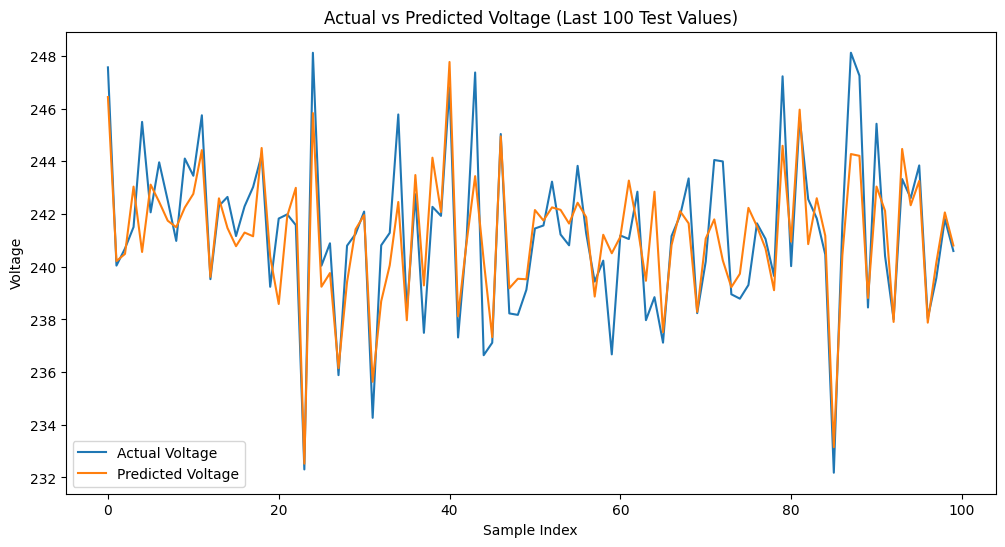

In [45]:
y_test_last = y_test[-100:].reset_index(drop=True)
y_pred_last = y_pred[-100:]

# Plotting actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_last, label='Actual Voltage')
plt.plot(y_pred_last, label='Predicted Voltage')
plt.title('Actual vs Predicted Voltage (Last 100 Test Values)')
plt.xlabel('Sample Index')
plt.ylabel('Voltage')
plt.legend()
plt.show()

# Xg Boost


In [46]:
from xgboost import XGBRegressor

In [47]:
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {'n_estimators': [10, 25, 50], 'max_depth': [10, 25, 50]}

grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(x_train, y_train)

print("Best Hyperparameters (XGBoost):", grid_search.best_params_)

y_pred = grid_search.predict(x_train)
train_mse = mean_squared_error(y_train, y_pred)
train_rmse = np.sqrt(train_mse)

print(f"Train Mean Squared Error: {train_mse}")
print(f"Train Root Mean Squared Error: {train_rmse}")

Best Hyperparameters (XGBoost): {'max_depth': 10, 'n_estimators': 50}
Train Mean Squared Error: 0.8373429812592503
Train Root Mean Squared Error: 0.9150644683623391


In [48]:
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=50, max_depth=10, random_state=42)
xgb_model.fit(x_train, y_train)
y_pred = xgb_model.predict(x_test)

test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)

print(f"Test Mean Squared Error: {test_mse}")
print(f"Test Root Mean Squared Error: {test_rmse}")

Test Mean Squared Error: 3.2283317491499064
Test Root Mean Squared Error: 1.7967558958160974


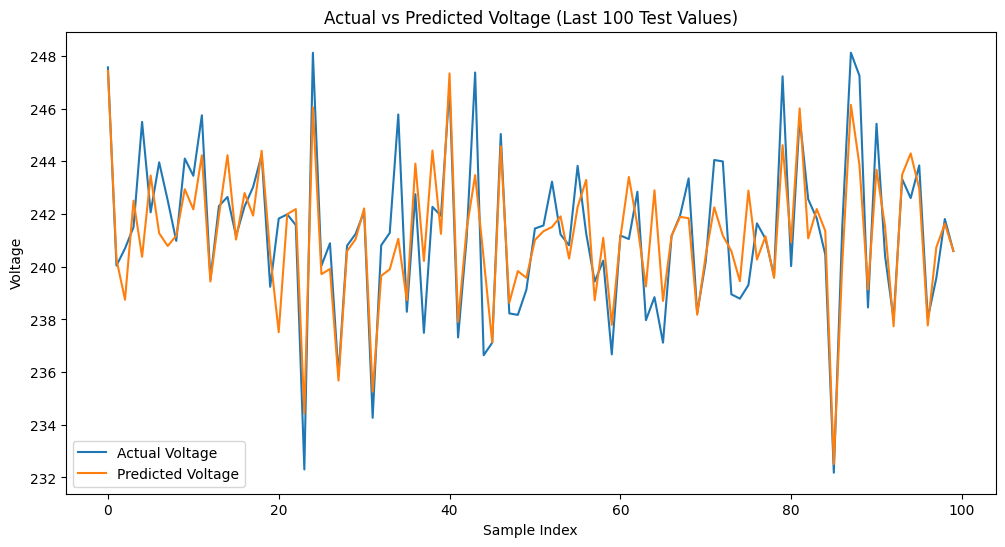

In [49]:
y_test_last = y_test[-100:].reset_index(drop=True)
y_pred_last = y_pred[-100:]

# Plotting actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_last, label='Actual Voltage')
plt.plot(y_pred_last, label='Predicted Voltage')
plt.title('Actual vs Predicted Voltage (Last 100 Test Values)')
plt.xlabel('Sample Index')
plt.ylabel('Voltage')
plt.legend()
plt.show()